In [1]:
# Workspace problem with several narrow gaps

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time

# (restrict tensorflow memory growth)
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
lr = 1e-4

# problem dimensions
dim = 6
dataElements = dim+3*3+2*dim # sample (6D), gap1 (2D, 1D orientation), gap2, gap3, init (6D), goal (6D)

z_dim = 3 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

In [3]:
# read in data from csv
filename = 'narrowDataFile.txt'
f = open(filename, 'rb')
reader = csv.reader(f, delimiter=',')
count = 0
data_list = []
for row in reader:
    data_list.append(map(float,row[0:dataElements]))

data = np.array(data_list,dtype='d')
numEntries = data.shape[0]

In [4]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim] # state: x, y, z, xdot, ydot, zdot
c_train = data[0:numTrain,dim:dataElements] # conditions: gaps, init (6), goal (6)

X_test = data[numTrain:numEntries,0:dim]
c_test = data[numTrain:numEntries,dim:dataElements]
numTest = X_test.shape[0]

In [5]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in range(0,obs.shape[0]/(2*dimW)):
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False;

# process data into occupancy grid
conditions = data[0:numEntries,dim:dataElements]
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = conditions[j,0:3]
    gap2 = conditions[j,3:6]
    gap3 = conditions[j,6:9]
    init = conditions[j,9:15]
    goal = conditions[j,15:21]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
    if plotOn:
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(0,obs.shape[0]/(2*dimW)): # plot obstacle patches
            ax1.add_patch(
            patches.Rectangle(
                (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
                obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
                obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
                alpha=0.6
            ))
        for i in range(0,gridSize*gridSize): # plot occupancy grid
            if occGrid[i] == 0:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=70, alpha=0.8)
            else:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=70, alpha=0.8)
        plt.show()
end = time.time();
print('Time: ', end-start)
    
cs = np.concatenate((data[0:numEntries,dim+3*dimW:dataElements], conditionsOcc), axis=1) # occ, init, goal
c_dim = cs.shape[1]
c_gapsInitGoal = c_test
c_train = cs[0:numTrain,:] 
c_test = cs[numTrain:numEntries,:]

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Iter: 35000
Iter: 40000
Iter: 45000
Iter: 50000
Iter: 55000
Iter: 60000
Iter: 65000
Iter: 70000
Iter: 75000
Iter: 80000
('Time: ', 60.17262887954712)


In [6]:
# define networks
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])

# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

# training
w = [[1, 1, 1, 0.5, 0.5, 0.5]];
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)
# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0;

In [7]:
for it in range(it,it+500001):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = X_train[batch_elements,:]
    c_mb = c_train[batch_elements,:]

    _, loss = sess.run([train_step, cvae_loss], feed_dict={X: X_mb, c: c_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

Iter: 0
Loss: 0.4629
()
Iter: 1000
Loss: 0.02059
()
Iter: 2000
Loss: 0.01988
()
Iter: 3000
Loss: 0.01804
()
Iter: 4000
Loss: 0.01831
()
Iter: 5000
Loss: 0.01726
()
Iter: 6000
Loss: 0.0145
()
Iter: 7000
Loss: 0.01465
()
Iter: 8000
Loss: 0.0131
()
Iter: 9000
Loss: 0.01355
()
Iter: 10000
Loss: 0.01429
()
Iter: 11000
Loss: 0.01208
()
Iter: 12000
Loss: 0.01148
()
Iter: 13000
Loss: 0.01284
()
Iter: 14000
Loss: 0.01102
()
Iter: 15000
Loss: 0.01168
()
Iter: 16000
Loss: 0.01164
()
Iter: 17000
Loss: 0.01044
()
Iter: 18000
Loss: 0.01111
()
Iter: 19000
Loss: 0.01072
()
Iter: 20000
Loss: 0.01007
()
Iter: 21000
Loss: 0.009847
()
Iter: 22000
Loss: 0.009671
()
Iter: 23000
Loss: 0.009779
()
Iter: 24000
Loss: 0.009827
()
Iter: 25000
Loss: 0.009825
()
Iter: 26000
Loss: 0.009381
()
Iter: 27000
Loss: 0.009457
()
Iter: 28000
Loss: 0.009019
()
Iter: 29000
Loss: 0.009711
()
Iter: 30000
Loss: 0.008912
()
Iter: 31000
Loss: 0.008813
()
Iter: 32000
Loss: 0.008848
()
Iter: 33000
Loss: 0.008564
()
Iter: 34000
Loss:

12227


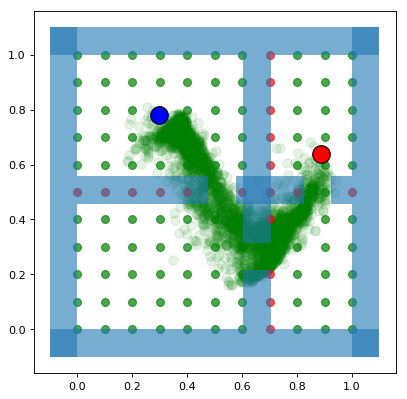

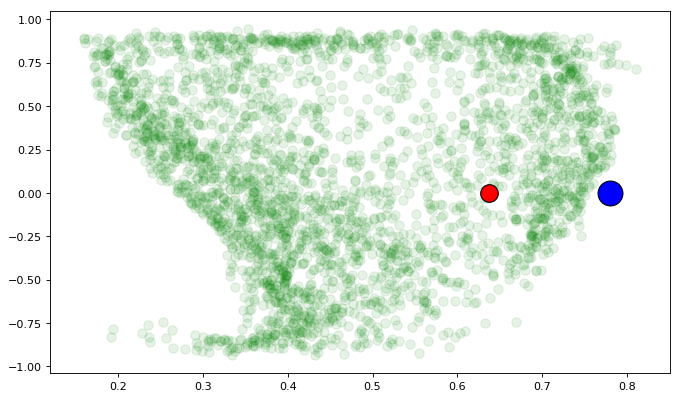

In [8]:
# plot the latent space
num_viz = 3000

vizIdx = randint(0,numTest-1);
print vizIdx
c_sample_seed = c_test[vizIdx,:]
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
c_viz = c_gapsInitGoal[vizIdx,:]

# directly sample from the latent space (preferred, what we will use in the end)
y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=70, alpha=0.1)

dw = 0.1
dimW = 3
gap1 = c_viz[0:3]
gap2 = c_viz[3:6]
gap3 = c_viz[6:9]
init = c_viz[9:15]
goal = c_viz[15:21]

obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
obsBounds = [-0.1, -0.1, -0.5, 0, 1.1, 1.5,
            -0.1, -0.1, -0.5, 1.1, 0, 1.5,
            -0.1, 1, -0.5, 1.1, 1.1, 1.5,
            1, -0.1, -0.5, 1.1, 1.1, 1.5,]

obs = np.concatenate((obs1, obs2, obs3, obs4, obs5, obsBounds), axis=0)
for i in range(0,obs.shape[0]/(2*dimW)):
    ax1.add_patch(
    patches.Rectangle(
        (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
        obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
        obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
        alpha=0.6
    ))
    
for i in range(0,gridSize*gridSize): # plot occupancy grid
    cIdx = i + 2*dim
    if c_sample_seed[cIdx] == 0:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=50, alpha=0.7)
    else:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=50, alpha=0.7)

plt.scatter(init[0], init[1], color="red", s=250, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=250, edgecolors='black') # goal

plt.show()

plt.figure(figsize=(10,6), dpi=80)
viz1 = 1;
viz2 = 4;
plt.scatter(y_viz[:,viz1],y_viz[:,viz2], color="green", s=70, alpha=0.1)
plt.scatter(c_viz[viz1+9],c_viz[viz2+9], color="red", s=250, edgecolors='black') # init
plt.scatter(c_viz[viz1+9+dim],c_viz[viz2+9+dim], color="blue", s=500, edgecolors='black') # goal
plt.show()